In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt
import seaborn as sns
import statsmodels as sm
from statsmodels.regression.linear_model import OLS
from sklearn.metrics import mean_squared_error as mse
# Imports
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.impute import MissingIndicator, SimpleImputer
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import accuracy_score, precision_score, recall_score, plot_roc_curve, plot_confusion_matrix
from sklearn.metrics import log_loss, classification_report
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, AdaBoostClassifier
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from collections import Counter
from xgboost import XGBClassifier
from scipy.stats import uniform
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
anes = pd.read_csv('data/anes_pilot_2020ets_csv.csv')

In [3]:
data = anes.copy(deep = True)

In [4]:
data.dropna(inplace=True)

In [5]:
data.drop(data[data['mis_covid1'] == 9].index, inplace=True)

In [6]:
data.drop(data[data['mis_covid2'] == 9].index, inplace=True)

In [10]:
data.rename(columns={"mis_covid1": 'covid_lab'}, inplace = True)

In [11]:
data.rename(columns={"mis_covid2": 'covid_vax'}, inplace = True)

In [13]:
data.covid_lab.replace((2,1), (0,1), inplace=True)

In [14]:
data.covid_vax.replace((2,1), (0,1), inplace=True)

In [15]:
data['covid_mis_score'] = data['covid_lab'] + data['covid_vax']


In [18]:
data.drop(inplace=True, columns=['covid_lab', 'covid_vax'])

In [27]:
data.drop(inplace=True, columns=[ 'votemail1b', 'V1', 'StartDate', 'EndDate', '_v1', 'RecordedDate', 
                                 'ResponseId','qmetadata_Browser', 'qmetadata_Version', '_v2', 
                                 'qmetadata_Resolution', 'check','relig1_11_TEXT', 'mauga', 'pk_cjus', 
                                 'pk_germ', 'ethnic1', 'ethnic2', 'ethnic3', 'mixed', 'hpi', 'asian', 'namer',
                                'black', 'white', 'race1_hpi', 'race1_asian', 'race1_namer', 'race1_black', 'race1_white',
                                'hispanicr', 'nonhispanic_white', 'hispanic_white', 'hispanic', 'pid2r', 'pk_index',
                                'survexp1', 'survexp2', 'dejavu', 'surv_comp', 'RAND_INC', 'XCONTACT', 'XFORGIVE', 'FEEDBACK_GROUP',
                                'INSTRUCTION_GROUP', 'form', 'serious', 'admit', 'geer1896', 'pk_sen', 'pk_spend', 'expshark',
                                'inc_cps', 'inc_cpsmod', 'marital2', 'whites_1', 'whites_2', 'whites_3',
                                'whites_4', 'whites_5', 'whites_6', 'whites_7', 'blacks_1', 'blacks_2', 'blacks_3',
                                'blacks_4', 'blacks_5', 'blacks_6', 'blacks_7', 'hisp_1', 'hisp_2', 'hisp_3',
                                'hisp_4', 'hisp_5', 'hisp_6', 'hisp_7', 'asians_1', 'asians_2', 'asians_3', 'asians_4',
                                'asians_5', 'asians_6','asians_7', 'survexp1', 'survexp2', 'dejavu', 'citizen1', 'citizen2',
                                'particip_count', 'pk_mauga_correct', 'pk_germ_correct', 'pk_cjus_correct', 'pk_sen_correct',
                                'pk_spend_correct', 'pk_cjus_correctb', 'pk_index', 'pidstr1_dr', 'pidstr1_ind', 'pidstr2_dr',
                                 'pidstr2_ind','pidstr3_dr', 'pidstr3_ind', 'pid7str', 'hispanic', 'hispanic_white', 'nonhispanic_white',
                                'hispanicr', 'race1_white', 'race1_black', 'race1_namer', 'race1_hpi', 'white', 'black',
                                'namer', 'asian', 'hpi', 'mixed'])

# dummy models: logistic & decision tree 

In [28]:
X = data
y = data['covid_mis_score']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 42)

In [29]:
#dummy classifier
dummy_model = DummyClassifier(strategy="most_frequent")
dummy_model.fit(X_train, y_train)
dummy_model.predict(X_train)
dummy_model.score(X_train, y_train)

0.4423076923076923

In [30]:
cross_val_score(dummy_model, X_train, y_train, cv = 5).mean()

0.44227642276422763

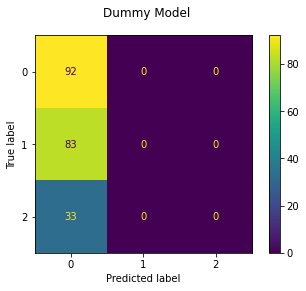

In [31]:
fig, ax = plt.subplots()

fig.suptitle("Dummy Model")

plot_confusion_matrix(dummy_model, X_train, y_train, ax=ax, values_format='');

In [32]:
# Obtain the accuracy, recall score, and precision score for the dummy model
y_pred_dummy = dummy_model.predict(X_test)

accuracy_dummy = accuracy_score(y_test, y_pred_dummy)
recall_dummy = recall_score(y_test, y_pred_dummy, average = 'micro')
precision_dummy = precision_score(y_test, y_pred_dummy, average = 'micro')

print(f"""
- Dummy Model - 
Accuracy score: {accuracy_dummy}
Recall score: {recall_dummy}
Precision score: {precision_dummy}
""")


- Dummy Model - 
Accuracy score: 0.33962264150943394
Recall score: 0.33962264150943394
Precision score: 0.33962264150943394



In [33]:
# logistic model dummy 

In [34]:
scale = StandardScaler()
X_train_scaled = scale.fit_transform(X_train)
X_test_scaled = scale.transform(X_test)

simple_log_model = LogisticRegression(random_state=42)
simple_log_model.fit(X_train_scaled, y_train)

LogisticRegression(random_state=42)

In [36]:
y_pred = simple_log_model.predict(X_test_scaled)

#recall score
recall = recall_score(y_test, y_pred, average='micro')
print(f"Recall score: {recall}")

Recall score: 0.5660377358490566


In [38]:
# Checking out to see if we overfit the data or not
y_pred_train = simple_log_model.predict(X_train_scaled)
y_pred_test = simple_log_model.predict(X_test_scaled)

print(f"Train Recall Score: {recall_score(y_train, y_pred_train, average='micro')}")
print(f"Test Recall Score: {recall_score(y_test, y_pred_test, average='micro')}")

Train Recall Score: 1.0
Test Recall Score: 0.5660377358490566


In [39]:
# looks like the training set is over fit, let's do some feature selection to see what is most important

In [40]:
# imputing code 

In [41]:
data_6 = ['pidstr',  'pidlean', 'pidstr1', 'pidstr2', 'pidstr3', 'relig2a',
     'att2', 'att3', 'fundmt1', 'fundmt2', 'whitejob', 'femid2_fem', 'femid2_anti',
     'femid2_nei', 'callout3a','callout3b','viol3_dems', 'viol3_reps', 'viol3_both']

In [42]:
for column in data_6:
    data[column].replace(6, np.nan, inplace=True)

In [43]:
data_9 = ['follow', 'votemail2', 'voterid1', 'voterid2', 'vote16', 'hopeful', 'worried', 'irritated', 'talk3', 
      'primaryvote', 'vote20jb', 'vote20bs', 'richpoor2', 'lcd', 'lcr', 'freemkt1a',
     'freemkt1b', 'govsize1a', 'govsize1b', 'ineqinc1a', 'antirelig1',
     'antirelig2', 'racist1','racist2', 'immignum', 'wall7', 'pathway', 
     'return', 'open', 'affact', 'hlthcare1', 'hlthcare2', 'covid1', 'covid2',
     'covid_elect', 'abort1', 'abort_imp', 'abort2', 'gayadopt', 'transmilit1a',
     'harass', 'diversity7', 'experts', 'science', 'exphelp', 'excessive',
     'compro1', 'compro2', 'pcorrect', 'selfcensor', 'childrear1', 'childrear2',
     'childrear3', 'rural2', 'rural3', 'rural4', 'conf_covid1', 'conf_covid2', 'impeach1', 'impeach2', 'pid1r', 
     'pidstr', 'pidlean', 'pidstr1', 'pidstr2', 'pidstr3', 'rr1', 'rr2',
     'rr3', 'rr4', 'relig2b', 'att1', 'att2', 'att3', 'fundmt1', 'fundmt2',
     'impact1', 'impact2', 'impact3', 'impact4', 'impact5', 'impact7', 'impact8',
     'impact9', 'whitejob', 'femid1a', 'femid1b', 'femid2_fem', 'knowtran1',
     'knowtran2_1', 'knowtran2_2', 'knowtran2_3', 'knowtran2_4', 'knowtran2_5',
     'knowtran2_6', 'knowgay1', 'knowgay2_1', 'knowgay2_2', 'knowgay2_3', 'knowgay2_4',
     'knowgay2_5', 'knowgay2_6', 'stress1', 'stress2', 'stress3', 'stress4',
     'depress1', 'depress2', 'depress3', 'depress4', 'depress5', 'callout1',
     'speech1', 'callout2', 'speech2', 'divmoral', 'forgive3', 'moralsup1',
     'duepro3', 'moralcert3', 'forgive5', 'intelsup1', 'moralcert1', 'duepro4',
     'moralcert6', 'forgive4', 'moralcert2', 'duepro1', 'callout3a','callout3b',
     'moralsup2', 'duepro2', 'intelsup2', 'duepro5', 'moralcert4', 'forgive6', 
     'moralcert5', 'link_bla','link_his', 'link_asi','link_whi', 'link_hpi', 'link_nat',
     'selfmon1', 'selfmon2', 'selfmon3', 'selfmon4', 'selfmon5', 'selfmon6', 'home_cps',
     'viol3_dems', 'viol3_reps', 'viol1', 'viol2a', 'viol2b', 'exptravel_ever', 
     'exphomesch', 'expconvert', 'expholiday', 'exparrest', 'exppubasst', 'expfight',
     'expavoid', 'callout_social', 'callout_person', 'expknowimmig', 'expbuyus',
     'expretire', 'expknowpris', 'marital1', 'home_ownership', 'vote20turnoutjb', 'pid7',
     'race7']

In [44]:
for column in data_9: 
    data[column].replace(9, np.nan, inplace=True)

In [45]:
data_77 = ['healthcarepres7', 'dtleader2', 'jbleader2', 
     'bsleader2', 'billtax2', 'guarinc2', 'freemkt2', 'freemkt3',
     'govsize2', 'govsize3', 'regulate2', 'strpres1b', 'transmilit1b',
     'freecol2', 'loans2']

In [46]:
for column in data_77: 
    data[column].replace(77, np.nan, inplace=True)

In [47]:
data_8 = ['turnout16a', 'turnout16a1', 'freemkt1a', 'freemkt1b',
     'govsize1a', 'govsize1b', 'antirelig1', 'antirelig2', 'racist1',
     'racist2', 'transmilit1a', 'pcorrect', 'selfcensor', 'relig2a',
     'femid1a', 'callout1', 'speech1', 'callout2', 'speech2', 'divmoral',
     'forgive3', 'moralsup1', 'duepro3', 'moralcert3', 'forgive5','intelsup1', 
     'moralcert1', 'duepro4', 'moralcert6', 'forgive4', 'moralcert2', 'duepro1',
     'callout3a','callout3b', 'moralsup2', 'duepro2', 'intelsup2', 'duepro5',
     'moralcert4', 'forgive6', 'moralcert5', 'home_anes', 'viol2a']

In [48]:
for column in data_8:
    data[column].replace(8, np.nan, inplace=True)

In [49]:
data_7 = ['turnout16b', 'relig2b', 'femid1b', 'stress1', 'stress2', 'stress3',
     'stress4', 'depress1', 'depress2', 'depress3', 'depress4', 'depress5', 
     'link_bla','link_his','link_asi','link_whi', 'link_hpi', 'link_nat',
     'selfmon1', 'selfmon2', 'selfmon3', 'selfmon4', 'selfmon5', 'selfmon6',
     'home_cps', 'viol2b']

In [50]:
for column in data_7:
    data[column].replace(7, np.nan, inplace=True)

In [51]:
data_99 = ['apppres7', 'frnpres7', 'immpres7', 'econpres7', 'healthcarepres7', 
     'dtcares', 'dtdignif', 'dtauth', 'dtdiv', 'dtknow', 'jbleader1',
     'jbleader2', 'jbcares', 'jbdignif', 'jbhonest', 'jbauth', 'jbdiv',
     'jbknow', 'bsleader1', 'bsleader2', 'bscares', 'bsdignif', 'bshonest',
     'bsauth', 'bsdiv', 'bsknow', 'freemkt2', 'freemkt3', 'govsize2', 'govsize3',
           'forgive1a', 'forgive1b','forgive2b','finworry', 'confecon', 'taxecon', 
     'regulate2', 'strpres1b', 'tol_rally', 'tol_pres', 'tol_teach',
     'transmilit1b', 'freecol2', 'forgive2a']

In [52]:
for column in data_99:
    data[column].replace(99, np.nan, inplace=True)

In [53]:
data_66 = ['freemkt2', 'freemkt3', 'govsize2', 'govsize3', 
     'facebook1', 'twitter1', 'forgive1a', 'forgive1b', 'forgive2a',
     'forgive2b', 'inc_anes']

In [54]:
for column in data_66: 
    data[column].replace(66, np.nan, inplace=True)

In [55]:
imp=SimpleImputer(missing_values= np.nan)
data_clean = pd.DataFrame(imp.fit_transform(data))
data_clean.columns = data.columns
data_clean.index = data.index 

ValueError: Length mismatch: Expected axis has 369 elements, new values have 370 elements